In [326]:
import datetime
import geopandas as gpd
import glob
import h3
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

import shapely
from shapely import Polygon
from shapely import wkt
from shapely.plotting import plot_polygon

from matplotlib.ticker import FuncFormatter


pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 100)

#Set color palette in code
colors = ['#8468F5','#EC74E7','#B2B2B2','#FFCB5C','#46B6E8','#2FD4A1','#333333']
sns.set_palette(sns.color_palette(colors), n_colors = 7)

# Basic H3 functions

# Getting a map of Finland using GADM (for plotting background)

In order to improve the plotting of the stations, I will download the multipolygon of Helsinki area.

In [327]:
import geopandas as gpd
from gadm import GADMDownloader
import numpy as np
import shapely
from shapely.ops import transform

def flip(x,y):
    return y,x

downloader = GADMDownloader(version="4.0")

country_name = "Finland"
ad_level = 2
gdf = downloader.get_shape_data_by_country_name(country_name=country_name, ad_level=ad_level)

# If latitude and longitude are flipped, perform this line:
#gdf.loc[0, 'geometry'] = transform(flip,gdf['geometry'].iloc[0])

gdf.head(3)

ID_0  COUNTRY           NAME_1 NL_NAME_1       ID_2             NAME_2  \
0  FIN  Finland  Eastern Finland            FIN.1.1_1      North Karelia   
1  FIN  Finland  Eastern Finland            FIN.1.2_1      North Savonia   
2  FIN  Finland  Eastern Finland            FIN.1.3_1  Päijänne Tavastia   

                         VARNAME_2 NL_NAME_2             TYPE_2 ENGTYPE_2  \
0    Pohjois-Karjala|Norra Karelen            Maakunta|landskap    Region   
1       Pohjois-Savo|Norra Savolax            Maakunta|landskap    Region   
2  Päijät-Häme|Päijänne Tavastland            Maakunta|landskap    Region   

  CC_2 HASC_2                                           geometry  
0              MULTIPOLYGON (((29.62012 61.93353, 29.62154 61...  
1              MULTIPOLYGON (((28.05437 62.28169, 28.04478 62...  
2              MULTIPOLYGON (((26.13442 61.15151, 26.12514 61...

<Axes: >

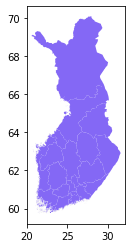

In [328]:
# Let's plot the whole map of Finland:
gdf.plot()

In [329]:
h3_df_area = pd.DataFrame([],columns=['h3_id', 'h3_centroid', 'polygon', 'area']) 

# The smaller the resolution integer, the larger the hexagon area.
resolution = 5

area_column = 'NAME_2'
# Convert multi-polygon into list of polygons
for ind in gdf.index.tolist():
    district_polygon = list(gdf['geometry'].iloc[ind].geoms) 
    area_name = gdf.iloc[ind][area_column]
    for polygon in district_polygon:
        # Convert Polygon to GeoJSON dictionary
        poly_geojson = gpd.GeoSeries([polygon]).__geo_interface__
        # Parse out geometry key from GeoJSON dictionary
        poly_geojson = poly_geojson['features'][0]['geometry'] 
        # Fill the dictionary with Resolution X H3 Hexagons
        h3_hexes = h3.polyfill_geojson(poly_geojson, resolution) 
        for h3_hex in h3_hexes:
            polygon = shapely.geometry.Polygon(h3.h3_to_geo_boundary(h3_hex, geo_json=True))
            h3_centroid = h3.h3_to_geo(h3_hex)
            # Append results to dataframe
            h3_df_area.loc[len(h3_df_area)]=[
                h3_hex,
                h3_centroid,
                polygon,
                area_name
            ]

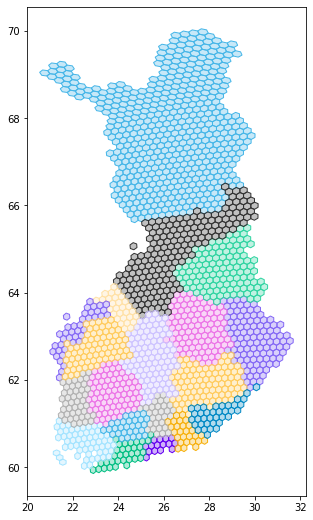

In [330]:
fig, ax = plt.subplots(figsize = (5,9))
areas = h3_df_area.area.unique().tolist()
for ind in h3_df_area.index.tolist():
    pol = h3_df_area.iloc[ind].polygon
    # In the beginning of the notebook, we defined plotting colors as a list (named colors). We have 14 different
    # colors specified in that list. We have more labels than we have colors in the color list so we need to add
    # %len(colors) to reuse some colors (% gives the remainder when dividing a number with another number.)
    area_color = areas.index(h3_df_area.iloc[ind].area) % len(colors)
    plot_polygon(pol, add_points=False, ax=ax, color=colors[area_color])

In [331]:
# Here we only need one area in Finland called Uusimaa, so let's take only that into account.
gdf = gdf[(gdf.NAME_2 == 'Uusimaa')|(gdf.NAME_2 == 'Eastern Uusimaa')].reset_index()

# Stations data

In [332]:
file_path = './bike_data/city-bike-stations-cleaned.csv'
df_stations = pd.read_csv(file_path)

df_stations.head()

ID            Name            Address   City  Capacity        lng  \
0  501       Hanasaari  Hanasaarenranta 1  Espoo        10  24.840319   
1  503      Keilalahti   Keilalahdentie 2  Espoo        28  24.827467   
2  505  Westendinasema     Westendintie 1  Espoo        16  24.805758   
3  507       Golfpolku        Golfpolku 3  Espoo        16  24.796136   
4  509   Revontulentie   Revontulentie 10  Espoo        30  24.802938   

         lat          h3_res6          h3_res7          h3_res8  \
0  60.165820  86089969fffffff  87089969affffff  88089969a3fffff   
1  60.171524  86089969fffffff  870899698ffffff  8808996985fffff   
2  60.168266  86089969fffffff  87089969effffff  880899698dfffff   
3  60.168143  86089969fffffff  87089969effffff  88089969ebfffff   
4  60.171551  86089969fffffff  870899698ffffff  880899698dfffff   

           h3_res9  Year  Year_last_used  
0  89089969a33ffff  2018            2021  
1  8908996984fffff  2018            2021  
2  890899698dbffff  2018            2021  
3  89089969eb7ffff  2018            2021  
4  890899698d3ffff  2018            2021

In [333]:
print("Number of stations: ", df_stations.ID.nunique())

Number of stations:  457


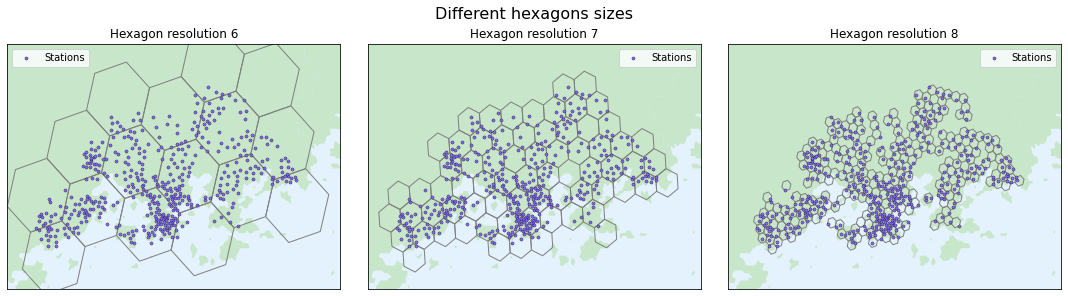

In [335]:
fig,ax = plt.subplot_mosaic("ABC", figsize = (15,4), constrained_layout=True)


xlims = [0.998*df_stations.lng.min(), 1.003*df_stations.lng.max()]
ylims = [0.9994*df_stations.lat.min(), 1.0006*df_stations.lat.max()]

fig.suptitle('Different hexagons sizes', size=16)

# ------------------------------
# First plot:
gdf.plot(ax=ax['A'], color='#C8E6C9', alpha=1)
ax['A'].set_facecolor('#E3F2FD')

col = 'h3_res6'
for ind in df_stations[col].unique().tolist():
    # With geo_json=True we get the lat and lng coordinates correctly.
    pol = Polygon(h3.h3_to_geo_boundary(ind, geo_json=True))
    plot_polygon(pol, add_points=False, ax=ax['A'], facecolor='None', edgecolor='gray', linewidth=1)

sns.scatterplot(data=df_stations, x='lng', y='lat', marker='o', s=10, color=colors[0], ax=ax['A'], label='Stations',
                edgecolor='black', linewidth=0.3)
ax['A'].set_xlim(xlims)
ax['A'].set_ylim(ylims)
ax['A'].set(title = 'Hexagon resolution 6')
    
ax['A'].get_xaxis().set_visible(False)
ax['A'].get_yaxis().set_visible(False)


# ------------------------------
# Second plot:
gdf.plot(ax=ax['B'], color='#C8E6C9', alpha=1)
ax['B'].set_facecolor('#E3F2FD')

col = 'h3_res7'
for ind in df_stations[col].unique().tolist():
    # With geo_json=True we get the lat and lng coordinates correctly.
    pol = Polygon(h3.h3_to_geo_boundary(ind, geo_json=True))
    plot_polygon(pol, add_points=False, ax=ax['B'], facecolor='None', edgecolor='gray', linewidth=1)
    
sns.scatterplot(data=df_stations, x='lng', y='lat', marker='o', s=10, color=colors[0], ax=ax['B'], label='Stations',
                edgecolor='black', linewidth=0.3)

ax['B'].set_xlim(xlims)
ax['B'].set_ylim(ylims)
ax['B'].set(title = 'Hexagon resolution 7')
    
ax['B'].get_xaxis().set_visible(False)
ax['B'].get_yaxis().set_visible(False)


# ------------------------------
# Third plot:
gdf.plot(ax=ax['C'], color='#C8E6C9', alpha=1)
ax['C'].set_facecolor('#E3F2FD')

col = 'h3_res8'
for ind in df_stations[col].unique().tolist():
    # With geo_json=True we get the lat and lng coordinates correctly.
    pol = Polygon(h3.h3_to_geo_boundary(ind, geo_json=True))
    plot_polygon(pol, add_points=False, ax=ax['C'], facecolor='None', edgecolor='gray', linewidth=1)
sns.scatterplot(data=df_stations, x='lng', y='lat', marker='o', s=10, color=colors[0], ax=ax['C'], label='Stations',
                edgecolor='black', linewidth=0.3)

ax['C'].set_xlim(xlims)
ax['C'].set_ylim(ylims)
ax['C'].set(title = 'Hexagon resolution 8')
    
ax['C'].get_xaxis().set_visible(False)
ax['C'].get_yaxis().set_visible(False)


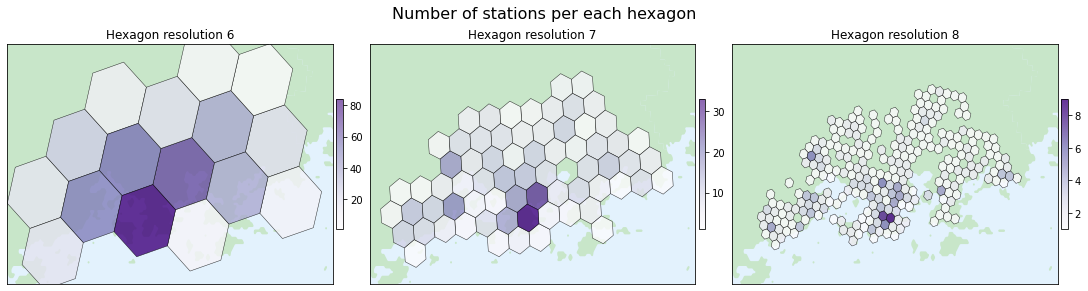

In [336]:
fig,ax = plt.subplot_mosaic("ABC",figsize = (15,4), constrained_layout=True)

xlims = [0.998*df_stations.lng.min(), 1.003*df_stations.lng.max()]
ylims = [0.9994*df_stations.lat.min(), 1.0006*df_stations.lat.max()]

fig.suptitle('Number of stations per each hexagon', size=16)

# ------------------------------
# First plot:
col_hexa = 'h3_res6'
col_by = "Name"
ax['A'].set_facecolor('#E3F2FD')
gdf.plot(ax=ax['A'], color='#C8E6C9', alpha=1)

num_trips = df_stations.groupby([col_hexa])[[col_by]].count().reset_index()
num_trips['color_norm'] = (num_trips[col_by]-num_trips[col_by].min())/ \
                          (num_trips[col_by].max()-num_trips[col_by].min())

for i in range(0, len(num_trips)):
    lat, lng = h3.h3_to_geo(num_trips.loc[i, col_hexa])
    num_trips.loc[i, 'lat'] = lat
    num_trips.loc[i, 'lng'] = lng
    
for i in range(0, len(num_trips)):
    ind = num_trips.loc[i, col_hexa]
    color = num_trips.loc[i, 'color_norm']
    # With geo_json=True we get the lat and lng coordinates correctly.
    pol = Polygon(h3.h3_to_geo_boundary(ind, geo_json=True))
    plot_polygon(pol, add_points=False, ax=ax['A'], alpha=0.8, color=cm.Purples(color), 
                 edgecolor='black', linewidth=0.5)
    
#sns.scatterplot(data=num_trips, x='lng', y='lat', hue=col_by, marker='o', s=100, linewidth=2,
#                palette='Purples', alpha=0)
ax['A'].set_xlim(xlims)
ax['A'].set_ylim(ylims)
ax['A'].set(title = 'Hexagon resolution 6')
norm = plt.Normalize(num_trips[col_by].min(), num_trips[col_by].max())
plt.colorbar(cm.ScalarMappable(cmap='Purples', norm=norm), fraction=0.02, pad=0.01, ax=ax['A'], alpha=0.6)

ax['A'].get_xaxis().set_visible(False)
ax['A'].get_yaxis().set_visible(False)


# ------------------------------
# Second plot:
col_hexa = 'h3_res7'
col_by = "Name"
ax['B'].set_facecolor('#E3F2FD')
gdf.plot(ax=ax['B'], color='#C8E6C9', alpha=1)

num_trips = df_stations.groupby([col_hexa])[[col_by]].count().reset_index()
num_trips['color_norm'] = (num_trips[col_by]-num_trips[col_by].min())/ \
                          (num_trips[col_by].max()-num_trips[col_by].min())

for i in range(0, len(num_trips)):
    lat, lng = h3.h3_to_geo(num_trips.loc[i, col_hexa])
    num_trips.loc[i, 'lat'] = lat
    num_trips.loc[i, 'lng'] = lng
    
for i in range(0, len(num_trips)):
    ind = num_trips.loc[i, col_hexa]
    color = num_trips.loc[i, 'color_norm']
    # With geo_json=True we get the lat and lng coordinates correctly.
    pol = Polygon(h3.h3_to_geo_boundary(ind, geo_json=True))
    plot_polygon(pol, add_points=False, ax=ax['B'], alpha=0.8, color=cm.Purples(color), 
                 edgecolor='black', linewidth=0.5)
    
#sns.scatterplot(data=num_trips, x='lng', y='lat', hue=col_by, marker='o', s=100, linewidth=2,
#                palette='Purples', alpha=0)
ax['B'].set_xlim(xlims)
ax['B'].set_ylim(ylims)
ax['B'].set(title = 'Hexagon resolution 7')
norm = plt.Normalize(num_trips[col_by].min(), num_trips[col_by].max())
plt.colorbar(cm.ScalarMappable(cmap='Purples', norm=norm), fraction=0.02, pad=0.01, ax=ax['B'], alpha=0.6)

ax['B'].get_xaxis().set_visible(False)
ax['B'].get_yaxis().set_visible(False)


# ------------------------------
# Third plot:
col_hexa = 'h3_res8'
col_by = "Name"
ax['C'].set_facecolor('#E3F2FD')
gdf.plot(ax=ax['C'], color='#C8E6C9', alpha=1)

num_trips = df_stations.groupby([col_hexa])[[col_by]].count().reset_index()
num_trips['color_norm'] = (num_trips[col_by]-num_trips[col_by].min())/ \
                          (num_trips[col_by].max()-num_trips[col_by].min())

for i in range(0, len(num_trips)):
    lat, lng = h3.h3_to_geo(num_trips.loc[i, col_hexa])
    num_trips.loc[i, 'lat'] = lat
    num_trips.loc[i, 'lng'] = lng
    
for i in range(0, len(num_trips)):
    ind = num_trips.loc[i, col_hexa]
    color = num_trips.loc[i, 'color_norm']
    # With geo_json=True we get the lat and lng coordinates correctly.
    pol = Polygon(h3.h3_to_geo_boundary(ind, geo_json=True))
    plot_polygon(pol, add_points=False, ax=ax['C'], alpha=0.8, color=cm.Purples(color), 
                 edgecolor='black', linewidth=0.5)
    
#sns.scatterplot(data=num_trips, x='lng', y='lat', hue=col_by, marker='o', s=100, linewidth=2,
#                palette='Purples', alpha=0)
ax['C'].set_xlim(xlims)
ax['C'].set_ylim(ylims)
ax['C'].set(title = 'Hexagon resolution 8')
norm = plt.Normalize(num_trips[col_by].min(), num_trips[col_by].max())
plt.colorbar(cm.ScalarMappable(cmap='Purples', norm=norm), fraction=0.02, pad=0.01, ax=ax['C'], alpha=0.8)

ax['C'].get_xaxis().set_visible(False)
ax['C'].get_yaxis().set_visible(False)

In [337]:
print("Number of hexagons resolution 6:", df_stations.h3_res6.nunique())
print("Number of hexagons resolution 7:", df_stations.h3_res7.nunique())
print("Number of hexagons resolution 8:", df_stations.h3_res8.nunique())

Number of hexagons resolution 6: 16
Number of hexagons resolution 7: 69
Number of hexagons resolution 8: 260


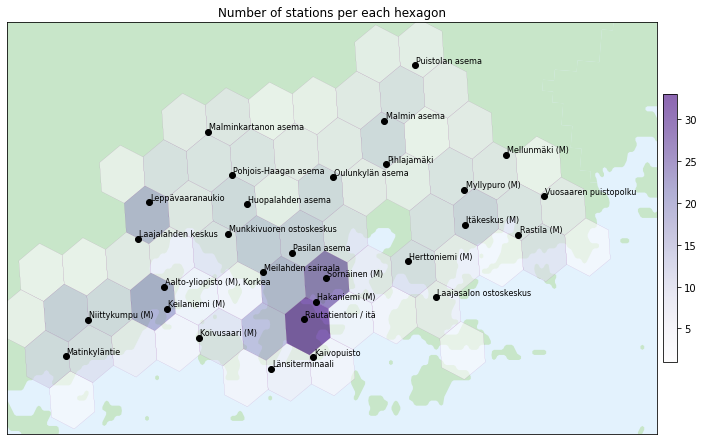

In [338]:
fig, ax = plt.subplots(figsize = (12,10))

col_hexa = 'h3_res7'
col_by = "Name"
ax.set_facecolor('#E3F2FD')
gdf.plot(ax=ax, color='#C8E6C9', alpha=1)

num_trips = df_stations.groupby([col_hexa])[[col_by]].count().reset_index()
num_trips['color_norm'] = (num_trips[col_by]-num_trips[col_by].min())/ \
                          (num_trips[col_by].max()-num_trips[col_by].min())

for i in range(0, len(num_trips)):
    lat, lng = h3.h3_to_geo(num_trips.loc[i, col_hexa])
    num_trips.loc[i, 'lat'] = lat
    num_trips.loc[i, 'lng'] = lng
    
for i in range(0, len(num_trips)):
    ind = num_trips.loc[i, col_hexa]
    color = num_trips.loc[i, 'color_norm']
    # With geo_json=True we get the lat and lng coordinates correctly.
    pol = Polygon(h3.h3_to_geo_boundary(ind, geo_json=True))
    plot_polygon(pol, add_points=False, ax=ax, alpha=0.6, color=cm.Purples(color),
                 edgecolor='purple', linewidth=0.1)
    
#sns.scatterplot(data=num_trips, x='lng', y='lat', hue=col_by, marker='o', s=100, linewidth=2,
#                palette='Purples', alpha=0)
ax.set_xlim([0.999*df_stations.lng.min(), 1.003*df_stations.lng.max()])
ax.set_ylim([0.9996*df_stations.lat.min(), 1.0002*df_stations.lat.max()])
ax.set(title = 'Number of stations per each hexagon')
norm = plt.Normalize(num_trips[col_by].min(), num_trips[col_by].max())
plt.colorbar(cm.ScalarMappable(cmap='Purples', norm=norm), fraction=0.02, pad=0.01, ax=ax, alpha=0.6)


ax.scatter(data=plot_names, x='lng', y='lat', color='black', zorder=3)
for i in plot_names.index.to_list():
    ax.annotate(plot_names.loc[i, 'Name'], 
                (0.001+plot_names.loc[i, 'lng'], 0.001+plot_names.loc[i, 'lat']), fontsize=8)

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

# Bike trips

In [339]:
directory_path = './bike_data/city-bike-trips-cleaned.csv'
df_trips = pd.read_csv(directory_path)

# Change the timestamps into datetime
df_trips['Departure'] = pd.to_datetime(df_trips['Departure'])
df_trips['Return'] = pd.to_datetime(df_trips['Return'])

df_trips['departure_date'] = pd.to_datetime(df_trips['departure_date'])
df_trips['return_date'] = pd.to_datetime(df_trips['return_date'])

df_trips.head()

Departure              Return  Departure station id  \
0 2018-06-30 23:59:56 2018-07-01 00:12:00                    44   
1 2018-06-30 23:59:33 2018-07-01 00:06:00                    22   
2 2018-06-30 23:59:27 2018-07-01 00:06:00                    27   
3 2018-06-30 23:59:23 2018-07-01 00:03:00                   127   
4 2018-06-30 23:59:23 2018-07-01 00:07:00                    27   

  Departure station name  Return station id    Return station name  \
0  Sörnäisten metroasema                 70        Sammonpuistikko   
1  Rautatientori / länsi                 22  Rautatientori / länsi   
2            Eerikinkatu                 63     Jätkäsaarenlaituri   
3             Teurastamo                125            Arielinkatu   
4            Eerikinkatu                 63     Jätkäsaarenlaituri   

   Covered distance (m)  Duration (sec.) departure_day_name  \
0                3199.0            756.0           Saturday   
1                 104.0            391.0           Saturday   
2                1247.0            422.0           Saturday   
3                 791.0            227.0           Saturday   
4                1251.0            485.0           Saturday   

   departure_weekday  departure_hour  departure_day  departure_month  \
0                  5              23             30                6   
1                  5              23             30                6   
2                  5              23             30                6   
3                  5              23             30                6   
4                  5              23             30                6   

  departure_date  departure_year return_day_name  return_weekday  return_hour  \
0     2018-06-30            2018          Sunday               6            0   
1     2018-06-30            2018          Sunday               6            0   
2     2018-06-30            2018          Sunday               6            0   
3     2018-06-30            2018          Sunday               6            0   
4     2018-06-30            2018          Sunday               6            0   

   return_day  return_month return_date  return_year  departure_ID  \
0           1             7  2018-07-01         2018          44.0   
1           1             7  2018-07-01         2018          22.0   
2           1             7  2018-07-01         2018          27.0   
3           1             7  2018-07-01         2018         127.0   
4           1             7  2018-07-01         2018          27.0   

   departure_lng  departure_lat departure_h3_res6 departure_h3_res7  \
0      24.960554      60.187713   861126d07ffffff   871126d06ffffff   
1      24.939760      60.170606   861126d37ffffff   871126d33ffffff   
2      24.936642      60.167706   861126d37ffffff   871126d33ffffff   
3      24.971157      60.189695   861126d07ffffff   871126d06ffffff   
4      24.936642      60.167706   861126d37ffffff   871126d33ffffff   

  departure_h3_res8 departure_h3_res9  return_ID  return_lng  return_lat  \
0   881126d061fffff   891126d0603ffff       70.0   24.922411   60.173147   
1   881126d331fffff   891126d338fffff       22.0   24.939760   60.170606   
2   881126d339fffff   891126d338bffff       63.0   24.921490   60.161931   
3   881126d063fffff   891126d063bffff      125.0   24.979739   60.185922   
4   881126d339fffff   891126d338bffff       63.0   24.921490   60.161931   

    return_h3_res6   return_h3_res7   return_h3_res8   return_h3_res9  
0  861126d37ffffff  871126d30ffffff  881126d303fffff  891126d3027ffff  
1  861126d37ffffff  871126d33ffffff  881126d331fffff  891126d338fffff  
2  861126d37ffffff  871126d30ffffff  881126d307fffff  891126d307bffff  
3  861126d07ffffff  871126d02ffffff  881126d067fffff  891126d066fffff  
4  861126d37ffffff  871126d30ffffff  881126d307fffff  891126d307bffff

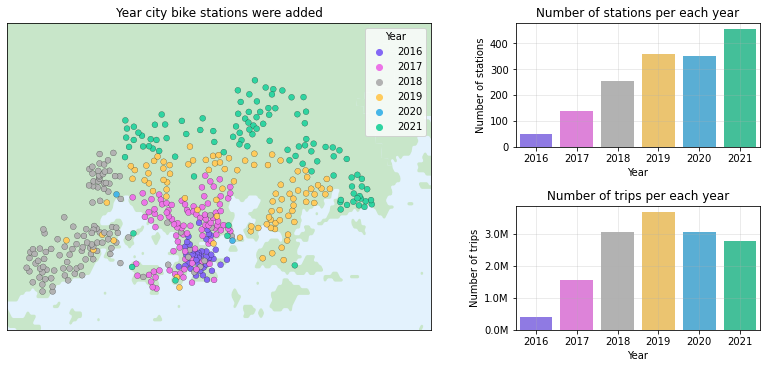

In [340]:
# For plotting, we might need millions formatter:
def millions(x, pos):
    'The two args are the value and tick position'
    return '%1.1fM' % (x * 1e-6)

fig,ax = plt.subplot_mosaic("AAB;AAC",figsize=(11,5),constrained_layout=True)

# First plot: map with bike stations
gdf.plot(ax=ax['A'], color='#C8E6C9', alpha=1)
ax['A'].set_facecolor('#E3F2FD')

sns.scatterplot(data=df_stations, x='lng', y='lat', hue='Year', ax= ax['A'], marker='o', s=35, linewidth=0.2,
                palette=[colors[0], colors[1], colors[2], colors[3], colors[4], colors[5]], edgecolor='black')
ax['A'].set_xlim([0.999*df_stations.lng.min(), 1.003*df_stations.lng.max()])
ax['A'].set_ylim([0.9996*df_stations.lat.min(), 1.0006*df_stations.lat.max()])
ax['A'].set(title = 'Year city bike stations were added')
    
ax['A'].get_xaxis().set_visible(False)
ax['A'].get_yaxis().set_visible(False)

# Second plot: number of stations per each year
use_data = df_trips.groupby(['departure_year'])[['Return station name']].nunique().reset_index()
sns.barplot(data=use_data, x='departure_year', y='Return station name', ax=ax['B'],
            palette=[colors[0], colors[1], colors[2], colors[3], colors[4], colors[5]])
ax['B'].set(title = 'Number of stations per each year', xlabel='Year', ylabel='Number of stations')
ax['B'].grid(alpha=0.3)

# Third plot: number of trips per each year
use_data = df_trips.groupby(['departure_year'])[['Return']].count().reset_index()
sns.barplot(data=use_data, x='departure_year', y='Return', ax=ax['C'], color='black',
            palette=[colors[0], colors[1], colors[2], colors[3], colors[4], colors[5]])
ax['C'].set(title = 'Number of trips per each year', xlabel='Year', ylabel='Number of trips')
ax['C'].grid(alpha=0.3)

formatter = FuncFormatter(millions)
ax['C'].yaxis.set_major_formatter(formatter)



# Combine trip data with stations
### Remove years 2016 and 2017 as there were so little data.

In [194]:
len_before = len(df_trips)

# Years 2016 and 2017 have limited amount of data and there's multiple issues with the stations ids from year 2016.
# Let's drop them from further analysis so that they don't have too big impact to the statistics.
df_trips = df_trips[pd.to_datetime(df_trips['Departure']).dt.year > 2017]

print("Numbers of rows removed: ", len_before - len(df_trips))

Numbers of rows removed:  1944069


In [221]:
df_trips.loc[(df_trips['Duration (sec.)'] < 10*60), 'duration_cat'] = '0-10 min'
df_trips.loc[(df_trips['Duration (sec.)'] >= 10*60)&(df_trips['Duration (sec.)'] < 20*60), 'duration_cat'] = '10-20 min'
df_trips.loc[(df_trips['Duration (sec.)'] >= 20*60)&(df_trips['Duration (sec.)'] < 30*60), 'duration_cat'] = '20-30 min'
df_trips.loc[(df_trips['Duration (sec.)'] >= 30*60), 'duration_cat'] = '30+ min'

df_trips.loc[(df_trips['Covered distance (m)'] < 1000), 'distance_cat'] = '0-1 km'
df_trips.loc[(df_trips['Covered distance (m)'] >= 1000) & (df_trips['Covered distance (m)'] < 3000), 'distance_cat'] = '1-3 km'
df_trips.loc[(df_trips['Covered distance (m)'] >= 3000) & (df_trips['Covered distance (m)'] < 5000), 'distance_cat'] = '3-5 km'
df_trips.loc[(df_trips['Covered distance (m)'] >= 5000), 'distance_cat'] = '5+ km'


## Check how much data has changed over the years 2017-2021

[Text(0, 0.5, 'Number of departures'),
 Text(0.5, 1.0, 'Daily amount of departures')]

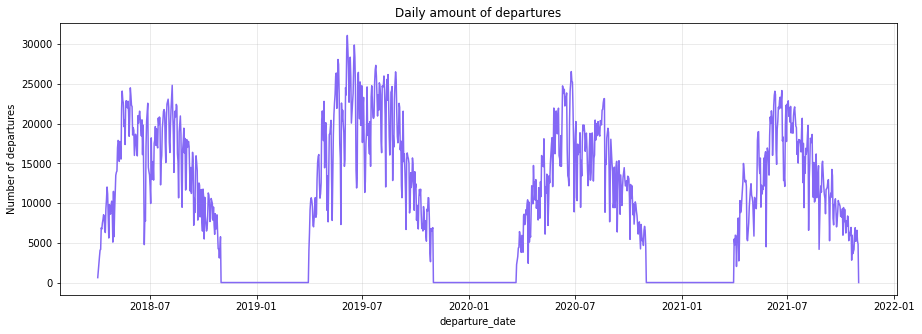

In [200]:
use_data = df_trips.groupby(['departure_date']).Departure.count().reset_index()

timerange =  pd.date_range(df_trips['departure_date'].min(),
                           df_trips['departure_date'].max()+pd.Timedelta(days=1),
                           freq='1d')
all_slots = pd.DataFrame({'time':timerange})

all_slots['departure_date'] = pd.to_datetime(all_slots['time'].dt.date)
use_data = pd.merge(all_slots, use_data, how="left", on=['departure_date'])
use_data.Departure = use_data.Departure.fillna(0)

use_data = use_data.groupby(['departure_date']).mean().reset_index()


fig, ax = plt.subplots(figsize = (15,5))
ax = sns.lineplot(data=use_data, x='departure_date', y='Departure')
ax.grid(alpha=0.3)
ax.set(ylabel='Number of departures', title = 'Daily amount of departures')

[Text(0, 0.5, 'Distance travelled'),
 Text(0.5, 1.0, 'Average distance travelled with city bikes')]

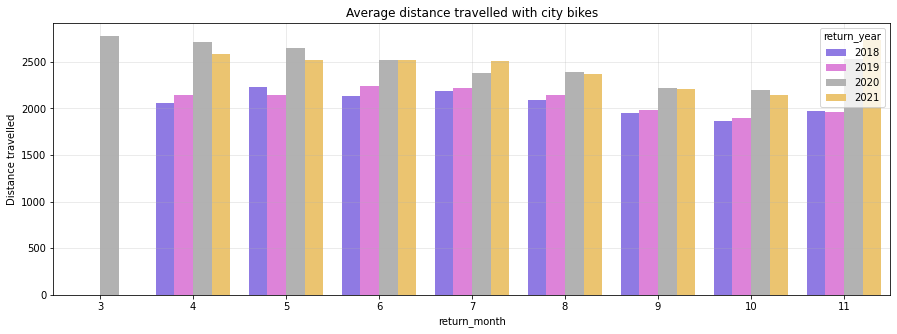

In [204]:
use_data = df_trips.groupby(['return_year', 'return_month'])[['Covered distance (m)']].mean().reset_index()

fig, ax = plt.subplots(figsize = (15,5))
ax = sns.barplot(data=use_data, x='return_month', y='Covered distance (m)', hue='return_year')
ax.grid(alpha=0.3)
ax.set(ylabel='Distance travelled', title = 'Average distance travelled with city bikes')

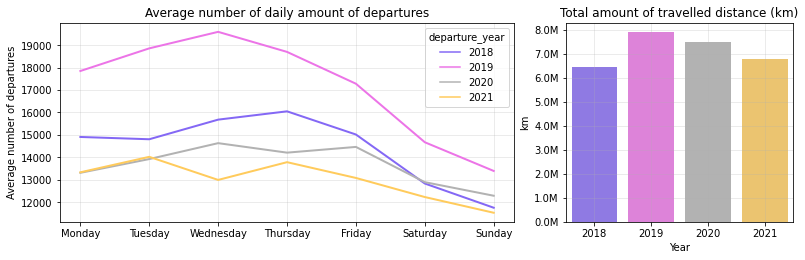

In [263]:
fig,ax = plt.subplot_mosaic("AAB",figsize=(11,3.5),constrained_layout=True)

# First plot:
use_data = df_trips.groupby(['departure_day_name', 'departure_weekday', 'departure_year', 'departure_date'])\
                   .Departure.count().reset_index()
use_data = use_data.groupby(['departure_day_name', 'departure_weekday', 'departure_year'])\
                   .Departure.mean().reset_index()

sns.lineplot(data=use_data.sort_values(by='departure_weekday'), x='departure_day_name', y='Departure', ax=ax['A'],
                  hue='departure_year', palette=[colors[0],colors[1],colors[2],colors[3]], linewidth=2)
ax['A'].grid(alpha=0.3)
ax['A'].set(ylabel='Average number of departures', title = 'Average number of daily amount of departures',
            xlabel=None)

# Second plot:

use_data = df_trips.groupby('departure_year')['Covered distance (m)'].sum().reset_index()
use_data['Covered distance (km)'] = use_data['Covered distance (m)']/1000

sns.barplot(data=use_data, x='departure_year', y='Covered distance (km)', ax=ax['B'], color='black',
            palette=[colors[0], colors[1], colors[2], colors[3]])
ax['B'].set(title = 'Total amount of travelled distance (km)', xlabel='Year', ylabel='km')
ax['B'].grid(alpha=0.3)

formatter = FuncFormatter(millions)
ax['B'].yaxis.set_major_formatter(formatter)

[Text(0.5, 1.0, 'Length of the trips'),
 Text(0, 0.5, '% of trips'),
 Text(0.5, 0, '')]

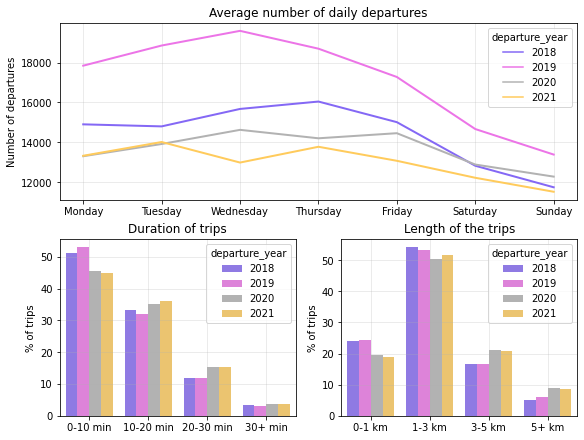

In [276]:
fig,ax = plt.subplot_mosaic("AA;BC",figsize=(8,6),constrained_layout=True)


# First plot:
use_data = df_trips.groupby(['departure_day_name', 'departure_weekday', 'departure_year', 'departure_date'])\
                   .Departure.count().reset_index()
use_data = use_data.groupby(['departure_day_name', 'departure_weekday', 'departure_year'])\
                   .Departure.mean().reset_index()

sns.lineplot(data=use_data.sort_values(by='departure_weekday'), x='departure_day_name', y='Departure', ax=ax['A'],
                  hue='departure_year', palette=[colors[0],colors[1],colors[2],colors[3]], linewidth=2)
ax['A'].grid(alpha=0.3)
ax['A'].set(ylabel='Number of departures', title = 'Average number of daily departures',
            xlabel=None)


# Second plot:
use_data = df_trips.groupby(['duration_cat','departure_year']).Departure.count().reset_index()
use_data['%'] = 100*use_data['Departure'] / use_data.groupby('departure_year')['Departure'].transform('sum')

sns.barplot(data=use_data, x='duration_cat', y='%', hue='departure_year', ax=ax['B'])
ax['B'].set(title='Length of the trips', ylabel='% of trips', xlabel=None)
ax['B'].grid(alpha=0.3)
ax['B'].set(title='Duration of trips', ylabel='% of trips', xlabel=None)


# Third plot:
use_data = df_trips.groupby(['distance_cat','departure_year']).Departure.count().reset_index()
use_data['%'] = 100*use_data['Departure'] / use_data.groupby('departure_year')['Departure'].transform('sum')

sns.barplot(data=use_data, x='distance_cat', y='%', hue='departure_year', ax=ax['C'])
ax['C'].set(title='Length of the trips', ylabel='% of trips', xlabel=None)
ax['C'].grid(alpha=0.3)
ax['C'].set(title='Length of the trips', ylabel='% of trips', xlabel=None)

[Text(0, 0.5, 'Number of departures'),
 Text(0.5, 1.0, 'Daily amount of departures')]

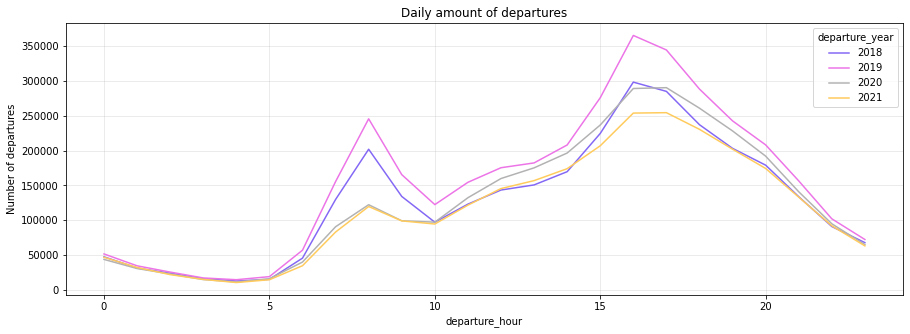

In [197]:
use_data = df_trips.groupby(['departure_hour', 'departure_year']).Departure.count().reset_index()

fig, ax = plt.subplots(figsize = (15,5))
ax = sns.lineplot(data=use_data, x='departure_hour', y='Departure', hue='departure_year',
                  palette=[colors[0],colors[1],colors[2],colors[3]])
ax.grid(alpha=0.3)
ax.set(ylabel='Number of departures', title = 'Daily amount of departures')

In [290]:
plot_names= ['Keilaniemi (M)', 'Leppävaaranaukio', 'Hakaniemi (M)', 'Kaivopuisto', 'Matinkyläntie', 'Pihlajamäki',
             'Itäkeskus (M)', 'Mellunmäki (M)', 'Puistolan asema', 'Malmin asema', 'Herttoniemi (M)',
             'Laajasalon ostoskeskus', 'Pasilan asema', 'Pohjois-Haagan asema', 'Malminkartanon asema']

plot_names = df_stations[df_stations.Name.isin(plot_names)]

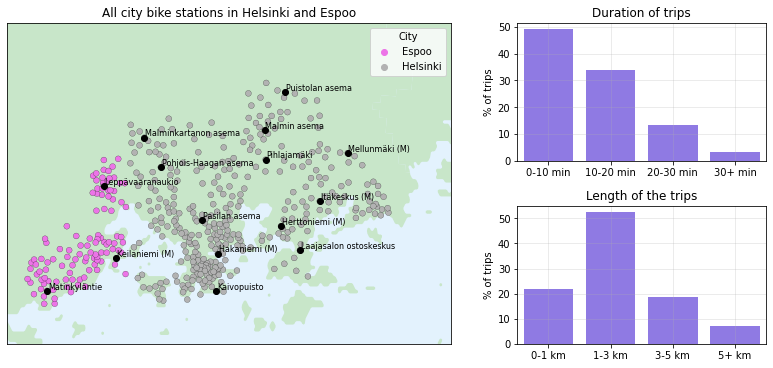

In [300]:
fig,ax = plt.subplot_mosaic("AAB;AAC",figsize=(11,5),constrained_layout=True)

# First plot: map with bike stations
gdf.plot(ax=ax['A'], color='#C8E6C9', alpha=1)
ax['A'].set_facecolor('#E3F2FD')

sns.scatterplot(data=df_stations, x='lng', y='lat', hue='City', ax= ax['A'], marker='o', s=35, linewidth=0.2,
                palette=[colors[1], colors[2]], edgecolor='black')
ax['A'].set_xlim([0.999*df_stations.lng.min(), 1.003*df_stations.lng.max()])
ax['A'].set_ylim([0.9996*df_stations.lat.min(), 1.0006*df_stations.lat.max()])
ax['A'].set(title = 'All city bike stations in Helsinki and Espoo')

ax['A'].scatter(data=plot_names, x='lng', y='lat', color='black', zorder=3)
for i in plot_names.index.to_list():
    ax['A'].annotate(plot_names.loc[i, 'Name'], 
                     (0.001+plot_names.loc[i, 'lng'], 0.001+plot_names.loc[i, 'lat']), fontsize=8)
    
ax['A'].get_xaxis().set_visible(False)
ax['A'].get_yaxis().set_visible(False)


# Second plot:
use_data = df_trips.groupby(['duration_cat']).Departure.count().reset_index()
use_data['%'] = 100*use_data['Departure'] / use_data.Departure.sum()

sns.barplot(data=use_data, x='duration_cat', y='%', ax=ax['B'], color=colors[0])
ax['B'].grid(alpha=0.3)
ax['B'].set(title='Duration of trips', ylabel='% of trips', xlabel=None)


# Third plot:
use_data = df_trips.groupby(['distance_cat']).Departure.count().reset_index()
use_data['%'] = 100*use_data['Departure'] / use_data.Departure.sum()

sns.barplot(data=use_data, x='distance_cat', y='%', ax=ax['C'], color=colors[0])
ax['C'].set(title='Length of the trips', ylabel='% of trips', xlabel=None)
ax['C'].grid(alpha=0.3)

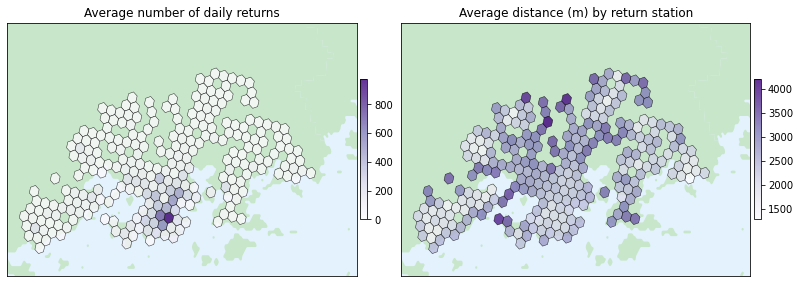

In [320]:
fig,ax = plt.subplot_mosaic("AB",figsize=(11,7),constrained_layout=True)

# First plot:
gdf.plot(ax=ax['A'], color='#C8E6C9', alpha=1)
ax['A'].set_facecolor('#E3F2FD')

col_hexa = 'return_h3_res8'
col_by = "Return"
num_trips = df_trips.groupby([col_hexa,'return_date'])[[col_by]].count().reset_index()
num_trips = num_trips.groupby([col_hexa])[[col_by]].mean().reset_index()
num_trips['color_norm'] = (num_trips[col_by])/ (num_trips[col_by].max())

for i in range(0, len(num_trips)):
    lat, lng = h3.h3_to_geo(num_trips.loc[i, col_hexa])
    num_trips.loc[i, 'lat'] = lat
    num_trips.loc[i, 'lng'] = lng
    
for i in range(0, len(num_trips)):
    ind = num_trips.loc[i, col_hexa]
    color = num_trips.loc[i, 'color_norm']
    # With geo_json=True we get the lat and lng coordinates correctly.
    pol = Polygon(h3.h3_to_geo_boundary(ind, geo_json=True))
    plot_polygon(pol, add_points=False, ax=ax['A'], alpha=0.8, color=cm.Purples(color), 
                 edgecolor='black', linewidth=0.5)
    
ax['A'].set_xlim([0.999*df_stations.lng.min(), 1.003*df_stations.lng.max()])
ax['A'].set_ylim([0.9996*df_stations.lat.min(), 1.0006*df_stations.lat.max()])
ax['A'].set(title = 'Average number of daily returns')
norm = plt.Normalize(0, num_trips[col_by].max())
plt.colorbar(cm.ScalarMappable(cmap='Purples', norm=norm), fraction=0.02, pad=0.01, ax=ax['A'], alpha=0.8)


ax['A'].get_xaxis().set_visible(False)
ax['A'].get_yaxis().set_visible(False)


# Second plot:

gdf.plot(ax=ax['B'], color='#C8E6C9', alpha=1)
ax['B'].set_facecolor('#E3F2FD')

col_hexa = 'return_h3_res8'
col_by = "Covered distance (m)"
num_trips = df_trips.groupby([col_hexa,'return_date'])[[col_by]].mean().reset_index()
num_trips = num_trips.groupby([col_hexa])[[col_by]].mean().reset_index()
num_trips['color_norm'] = (num_trips[col_by]-num_trips[col_by].min())/ \
                          (num_trips[col_by].max()-num_trips[col_by].min())

for i in range(0, len(num_trips)):
    lat, lng = h3.h3_to_geo(num_trips.loc[i, col_hexa])
    num_trips.loc[i, 'lat'] = lat
    num_trips.loc[i, 'lng'] = lng
    
for i in range(0, len(num_trips)):
    ind = num_trips.loc[i, col_hexa]
    color = num_trips.loc[i, 'color_norm']
    # With geo_json=True we get the lat and lng coordinates correctly.
    pol = Polygon(h3.h3_to_geo_boundary(ind, geo_json=True))
    plot_polygon(pol, add_points=False, ax=ax['B'], alpha=0.8, color=cm.Purples(color), 
                 edgecolor='black', linewidth=0.5)
    
ax['B'].set_xlim([0.999*df_stations.lng.min(), 1.003*df_stations.lng.max()])
ax['B'].set_ylim([0.9996*df_stations.lat.min(), 1.0006*df_stations.lat.max()])
ax['B'].set(title = 'Average distance (m) by return station')
norm = plt.Normalize(num_trips[col_by].min(), num_trips[col_by].max())
plt.colorbar(cm.ScalarMappable(cmap='Purples', norm=norm), fraction=0.02, pad=0.01, ax=ax['B'], alpha=0.8)

ax['B'].get_xaxis().set_visible(False)
ax['B'].get_yaxis().set_visible(False)



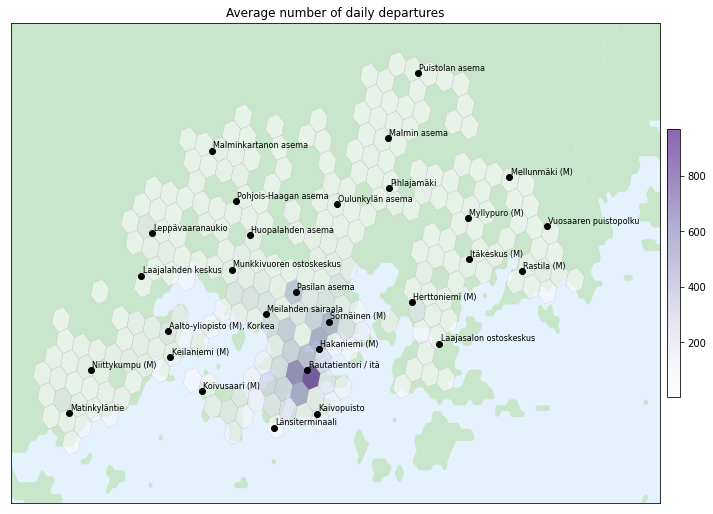

In [77]:
fig, ax = plt.subplots(figsize = (12,10))

col_hexa = 'departure_h3_res8'
col_by = "Departure"
ax.set_facecolor('#E3F2FD')
gdf.plot(ax=ax, color='#C8E6C9', alpha=1)
num_trips = df_trips.groupby([col_hexa,'departure_date'])[[col_by]].count().reset_index()
num_trips = num_trips.groupby([col_hexa])[[col_by]].mean().reset_index()
num_trips['color_norm'] = (num_trips[col_by]-num_trips[col_by].min())/ \
                          (num_trips[col_by].max()-num_trips[col_by].min())

for i in range(0, len(num_trips)):
    lat, lng = h3.h3_to_geo(num_trips.loc[i, col_hexa])
    num_trips.loc[i, 'lat'] = lat
    num_trips.loc[i, 'lng'] = lng
    
for i in range(0, len(num_trips)):
    ind = num_trips.loc[i, col_hexa]
    color = num_trips.loc[i, 'color_norm']
    # With geo_json=True we get the lat and lng coordinates correctly.
    pol = Polygon(h3.h3_to_geo_boundary(ind, geo_json=True))
    plot_polygon(pol, add_points=False, ax=ax, alpha=0.6, color=cm.Purples(color), edgecolor='purple', linewidth=0.1)
    
#sns.scatterplot(data=num_trips, x='lng', y='lat', hue=col_by, marker='o', s=100, linewidth=2,
#                palette='Purples', alpha=0)
ax.set_xlim([0.999*df_stations.lng.min(), 1.003*df_stations.lng.max()])
ax.set_ylim([0.9996*df_stations.lat.min(), 1.0002*df_stations.lat.max()])
ax.set(title = 'Average number of daily departures')
norm = plt.Normalize(num_trips[col_by].min(), num_trips[col_by].max())
plt.colorbar(cm.ScalarMappable(cmap='Purples', norm=norm), fraction=0.02, pad=0.01, ax=ax, alpha=0.6)


ax.scatter(data=plot_names, x='lng', y='lat', color='black', zorder=3)
for i in plot_names.index.to_list():
    ax.annotate(plot_names.loc[i, 'Nimi'], 
                (0.001+plot_names.loc[i, 'lng'], 0.001+plot_names.loc[i, 'lat']), fontsize=8)

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

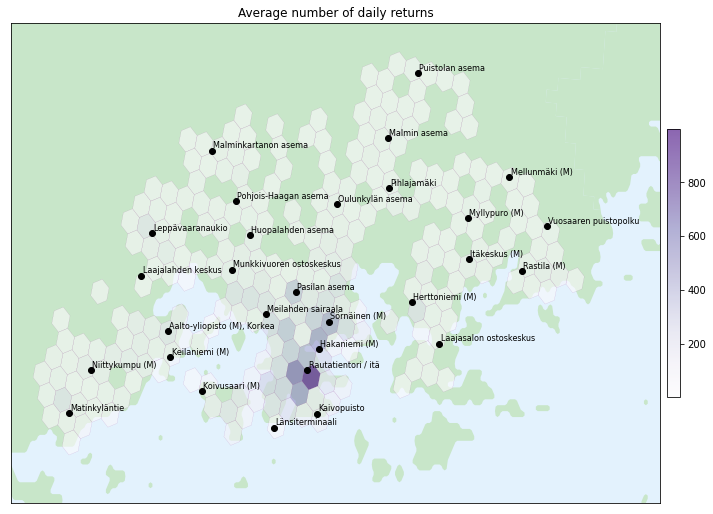

In [78]:
fig, ax = plt.subplots(figsize = (12,10))

col_hexa = 'return_h3_res8'
col_by = "Return"
ax.set_facecolor('#E3F2FD')
gdf.plot(ax=ax, color='#C8E6C9', alpha=1)
num_trips = df_trips.groupby([col_hexa,'return_date'])[[col_by]].count().reset_index()
num_trips = num_trips.groupby([col_hexa])[[col_by]].mean().reset_index()
num_trips['color_norm'] = (num_trips[col_by]-num_trips[col_by].min())/ \
                          (num_trips[col_by].max()-num_trips[col_by].min())

for i in range(0, len(num_trips)):
    lat, lng = h3.h3_to_geo(num_trips.loc[i, col_hexa])
    num_trips.loc[i, 'lat'] = lat
    num_trips.loc[i, 'lng'] = lng
    
for i in range(0, len(num_trips)):
    ind = num_trips.loc[i, col_hexa]
    color = num_trips.loc[i, 'color_norm']
    # With geo_json=True we get the lat and lng coordinates correctly.
    pol = Polygon(h3.h3_to_geo_boundary(ind, geo_json=True))
    plot_polygon(pol, add_points=False, ax=ax, alpha=0.6, color=cm.Purples(color), edgecolor='purple', linewidth=0.1)
    
#sns.scatterplot(data=num_trips, x='lng', y='lat', hue=col_by, marker='o', s=100, linewidth=2,
#                palette='Purples', alpha=0)
ax.set_xlim([0.999*df_stations.lng.min(), 1.003*df_stations.lng.max()])
ax.set_ylim([0.9996*df_stations.lat.min(), 1.0002*df_stations.lat.max()])
ax.set(title = 'Average number of daily returns')
norm = plt.Normalize(num_trips[col_by].min(), num_trips[col_by].max())
plt.colorbar(cm.ScalarMappable(cmap='Purples', norm=norm), fraction=0.02, pad=0.01, ax=ax, alpha=0.6)


ax.scatter(data=plot_names, x='lng', y='lat', color='black', zorder=3)
for i in plot_names.index.to_list():
    ax.annotate(plot_names.loc[i, 'Nimi'], 
                (0.001+plot_names.loc[i, 'lng'], 0.001+plot_names.loc[i, 'lat']), fontsize=8)

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

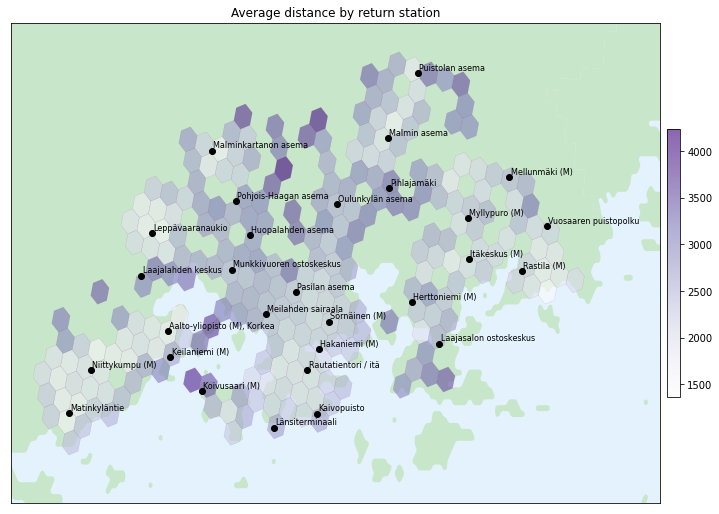

In [84]:
fig, ax = plt.subplots(figsize = (12,10))

col_hexa = 'return_h3_res8'
col_by = "Covered distance (m)"
ax.set_facecolor('#E3F2FD')
gdf.plot(ax=ax, color='#C8E6C9', alpha=1)
num_trips = df_trips.groupby([col_hexa,'return_date'])[[col_by]].mean().reset_index()
num_trips = num_trips.groupby([col_hexa])[[col_by]].mean().reset_index()
num_trips['color_norm'] = (num_trips[col_by]-num_trips[col_by].min())/ \
                          (num_trips[col_by].max()-num_trips[col_by].min())

for i in range(0, len(num_trips)):
    lat, lng = h3.h3_to_geo(num_trips.loc[i, col_hexa])
    num_trips.loc[i, 'lat'] = lat
    num_trips.loc[i, 'lng'] = lng
    
for i in range(0, len(num_trips)):
    ind = num_trips.loc[i, col_hexa]
    color = num_trips.loc[i, 'color_norm']
    # With geo_json=True we get the lat and lng coordinates correctly.
    pol = Polygon(h3.h3_to_geo_boundary(ind, geo_json=True))
    plot_polygon(pol, add_points=False, ax=ax, alpha=0.6, color=cm.Purples(color), edgecolor='purple', linewidth=0.1)
    
#sns.scatterplot(data=num_trips, x='lng', y='lat', hue=col_by, marker='o', s=100, linewidth=2,
#                palette='Purples', alpha=0)
ax.set_xlim([0.999*df_stations.lng.min(), 1.003*df_stations.lng.max()])
ax.set_ylim([0.9996*df_stations.lat.min(), 1.0002*df_stations.lat.max()])
ax.set(title = 'Average distance by return station')
norm = plt.Normalize(num_trips[col_by].min(), num_trips[col_by].max())
plt.colorbar(cm.ScalarMappable(cmap='Purples', norm=norm), fraction=0.02, pad=0.01, ax=ax, alpha=0.6)


ax.scatter(data=plot_names, x='lng', y='lat', color='black', zorder=3)
for i in plot_names.index.to_list():
    ax.annotate(plot_names.loc[i, 'Nimi'], 
                (0.001+plot_names.loc[i, 'lng'], 0.001+plot_names.loc[i, 'lat']), fontsize=8)

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

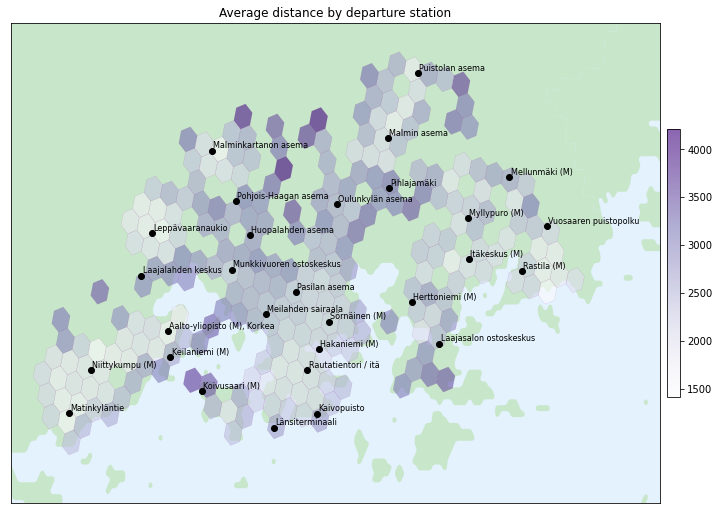

In [83]:
fig, ax = plt.subplots(figsize = (12,10))

col_hexa = 'departure_h3_res8'
col_by = "Covered distance (m)"
ax.set_facecolor('#E3F2FD')
gdf.plot(ax=ax, color='#C8E6C9', alpha=1)
num_trips = df_trips.groupby([col_hexa,'departure_date'])[[col_by]].mean().reset_index()
num_trips = num_trips.groupby([col_hexa])[[col_by]].mean().reset_index()
num_trips['color_norm'] = (num_trips[col_by]-num_trips[col_by].min())/ \
                          (num_trips[col_by].max()-num_trips[col_by].min())

for i in range(0, len(num_trips)):
    lat, lng = h3.h3_to_geo(num_trips.loc[i, col_hexa])
    num_trips.loc[i, 'lat'] = lat
    num_trips.loc[i, 'lng'] = lng
    
for i in range(0, len(num_trips)):
    ind = num_trips.loc[i, col_hexa]
    color = num_trips.loc[i, 'color_norm']
    # With geo_json=True we get the lat and lng coordinates correctly.
    pol = Polygon(h3.h3_to_geo_boundary(ind, geo_json=True))
    plot_polygon(pol, add_points=False, ax=ax, alpha=0.6, color=cm.Purples(color), edgecolor='purple', linewidth=0.1)
    
#sns.scatterplot(data=num_trips, x='lng', y='lat', hue=col_by, marker='o', s=100, linewidth=2,
#                palette='Purples', alpha=0)
ax.set_xlim([0.999*df_stations.lng.min(), 1.003*df_stations.lng.max()])
ax.set_ylim([0.9996*df_stations.lat.min(), 1.0002*df_stations.lat.max()])
ax.set(title = 'Average distance by departure station')
norm = plt.Normalize(num_trips[col_by].min(), num_trips[col_by].max())
plt.colorbar(cm.ScalarMappable(cmap='Purples', norm=norm), fraction=0.02, pad=0.01, ax=ax, alpha=0.6)


ax.scatter(data=plot_names, x='lng', y='lat', color='black', zorder=3)
for i in plot_names.index.to_list():
    ax.annotate(plot_names.loc[i, 'Nimi'], 
                (0.001+plot_names.loc[i, 'lng'], 0.001+plot_names.loc[i, 'lat']), fontsize=8)

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

# Select one hexagon

In [181]:
df_stations[df_stations.h3_res7=='871126d33ffffff'].Kapasiteet.sum()

762

In [183]:
df_trips["Departure station id"].nunique()

465

[Text(0, 0.5, 'Number of departures'),
 Text(0.5, 1.0, 'Departures of citybikes')]

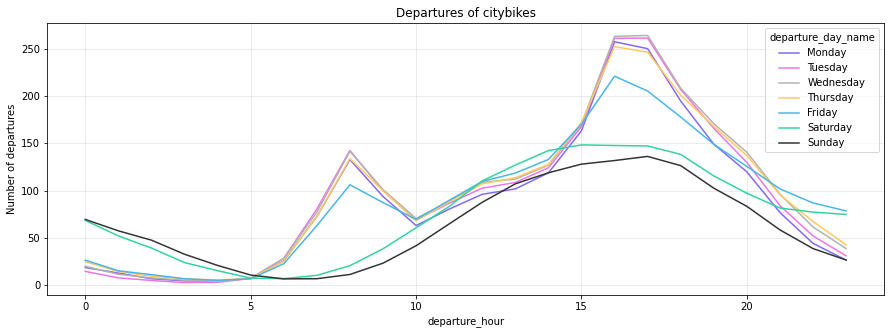

In [28]:
# The highest number of trips:
hex_id = '871126d33ffffff'
hexa_trips = df_trips[ df_trips['departure_h3_res7'] == hex_id ]

use_data = hexa_trips.groupby(['departure_day_name', 'departure_weekday','departure_hour','departure_date'])\
                     .Departure.count().reset_index()

timerange =  pd.date_range(use_data['departure_date'].min(), use_data['departure_date'].max()+pd.Timedelta(days=1),
                           freq='1h')
all_slots = pd.DataFrame({'time':timerange})
all_slots['departure_hour'] = all_slots['time'].dt.hour
all_slots['departure_date'] = all_slots['time'].dt.date
all_slots['departure_weekday'] = all_slots['time'].dt.dayofweek
all_slots['departure_day_name'] = all_slots['time'].dt.day_name()
use_data = pd.merge(all_slots, use_data, how="left",
                    on=['departure_date', 'departure_hour', 'departure_weekday', 'departure_day_name'])
use_data.Departure = use_data.Departure.fillna(0)

use_data = use_data.groupby(['departure_hour','departure_weekday','departure_day_name']).mean().reset_index()


fig, ax = plt.subplots(figsize = (15,5))
ax = sns.lineplot(data=use_data.sort_values(by='departure_weekday'), x='departure_hour', y='Departure',
                  hue='departure_day_name')
ax.grid(alpha=0.3)
ax.set(ylabel='Number of departures', title = 'Departures of citybikes')

[Text(0, 0.5, 'Number of returns'), Text(0.5, 1.0, 'Returns of citybikes')]

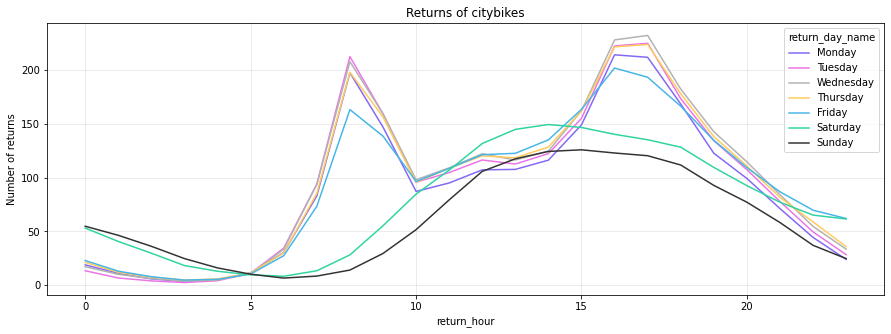

In [29]:
# The highest number of trips:
hex_id = '871126d33ffffff'
hexa_trips = df_trips[ df_trips['return_h3_res7'] == hex_id ]

use_data = hexa_trips.groupby(['return_day_name', 'return_weekday','return_hour','return_date']).Return\
                     .count().reset_index()

timerange =  pd.date_range(use_data['return_date'].min(), use_data['return_date'].max()+pd.Timedelta(days=1),
                           freq='1h')
all_slots = pd.DataFrame({'time':timerange})
all_slots['return_hour'] = all_slots['time'].dt.hour
all_slots['return_date'] = all_slots['time'].dt.date
all_slots['return_weekday'] = all_slots['time'].dt.dayofweek
all_slots['return_day_name'] = all_slots['time'].dt.day_name()
use_data = pd.merge(all_slots, use_data, how="left",
                    on=['return_date', 'return_hour', 'return_weekday', 'return_day_name'])
use_data.Return = use_data.Return.fillna(0)

use_data = use_data.groupby(['return_hour','return_weekday','return_day_name']).mean().reset_index()

fig, ax = plt.subplots(figsize = (15,5))
ax = sns.lineplot(data=use_data.sort_values(by='return_weekday'), x='return_hour', y='Return',
                  hue='return_day_name')
ax.grid(alpha=0.3)
ax.set(ylabel='Number of returns', title = 'Returns of citybikes')

[Text(0, 0.5, 'Division'),
 Text(0.5, 1.0, 'Average number of returns minus number on departures')]

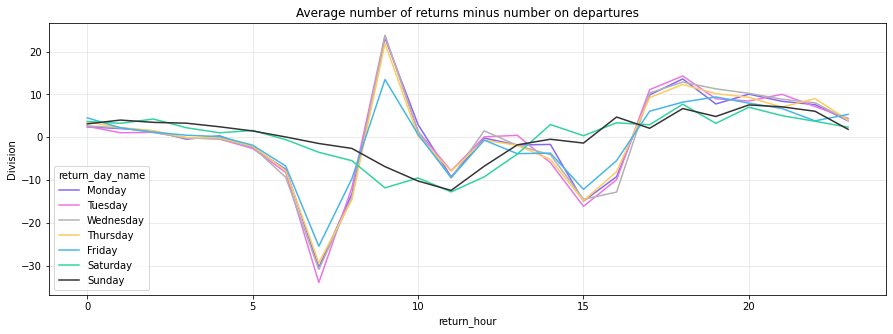

In [200]:
ret_data = hexa_trips.groupby(['return_day_name', 'return_weekday','return_hour','return_date'])\
                     .Return.count().reset_index()
dep_data = hexa_trips.groupby(['departure_day_name', 'departure_weekday','departure_hour','departure_date'])\
                     .Departure.count().reset_index()

use_data = pd.merge(ret_data, dep_data, how="inner", left_on=['return_date', 'return_hour'],
                    right_on=['departure_date', 'departure_hour'])
use_data['Minus'] = use_data['Return']-use_data['Departure']
use_data = use_data.groupby(['return_hour','return_weekday','return_day_name']).Minus.mean().reset_index()

fig, ax = plt.subplots(figsize = (15,5))
ax = sns.lineplot(data=use_data.sort_values(by='return_weekday'), x='return_hour', y='Minus', hue='return_day_name')
ax.grid(alpha=0.3)
ax.set(ylabel='Division', title = 'Average number of returns minus number on departures')

# H3 library functions

In [341]:
resolution = 9
lat, lng = 60.16582, 24.840319
h3_id = h3.geo_to_h3(lat, lng, resolution)
h3_id

'89089969a33ffff'

In [342]:
h3.h3_to_geo('89089969a33ffff')

(60.16676242910275, 24.842192178738227)

In [343]:
import inspect
inspect.signature(plot_polygon)

<Signature (polygon, ax=None, add_points=True, color=None, facecolor=None, edgecolor=None, linewidth=None, **kwargs)>

# Folium visualizations

In [344]:
from h3 import h3
import folium
import leafmap.foliumap as leafmap

center_lng = df_stations.lng.mean()
center_lat = df_stations.lat.mean()


def init_map(zoom=11):
    return folium.Map(location= [center_lat, center_lng], zoom_start=zoom, tiles="cartodbpositron")

def visualize_hexagons(hexagons, color="black", fill_color="purple", w=2, folium_map=None):
    """
    hexagons is a list of hexcluster. Each hexcluster is a list of hexagons. 
    eg. [[hex1, hex2], [hex3, hex4]]
    """
    polylines = []
    lat = []
    lng = []
    for hex in hexagons:
        polygons = h3.h3_set_to_multi_polygon([hex], geo_json=False)
        # flatten polygons into loops.
        outlines = [loop for polygon in polygons for loop in polygon]
        polyline = [outline + [outline[0]] for outline in outlines][0]
        lat.extend(map(lambda v:v[0],polyline))
        lng.extend(map(lambda v:v[1],polyline))
        polylines.append(polyline)
    
    if folium_map is None:
        m = init_map()
    else:
        m = folium_map
    for polyline in polylines:
        my_PolyLine=folium.PolyLine(locations=polyline, weight=w, color=color, fill_color=fill_color)
        m.add_child(my_PolyLine)
    return m

def visualize_points(lat, lng, color='black', folium_map=None, r=2):
    if folium_map is None:
        m = init_map()
    else:
        m = folium_map
        
    for i in range(0, len(lat)):
        scatter_marker = folium.CircleMarker(location=[lat[i], lng[i]], radius=r, color=color, fill_color=color)
        m.add_child(scatter_marker)
        
    return m
    

def visualize_polygon(polyline, color):
    polyline.append(polyline[0])
    lat = [p[0] for p in polyline]
    lng = [p[1] for p in polyline]
    #m = folium.Map(location=[sum(lat)/len(lat), sum(lng)/len(lng)], zoom_start=13, tiles='cartodbpositron')
    m = folium.Map(location=[center_lat, center_lng], zoom_start=13, tiles='openstreetmap')
    my_PolyLine=folium.PolyLine(locations=polyline,weight=8,color=color)
    m.add_child(my_PolyLine)
    return m

def visualize_line(start_lat, start_lng, end_lat, end_lng, color='red', w=2, folium_map=None):
    if folium_map is None:
        m = init_map()
    else:
        m = folium_map
        
    for i in range(0, len(start_lat)):
        line = folium.PolyLine(locations = [[start_lat[i], start_lng[i]], [end_lat[i], end_lng[i]]],
                               weight=w, color=color)
        m.add_child(line)
    return m

In [357]:
df_stations.head()

ID            Name            Address   City  Capacity        lng  \
0  501       Hanasaari  Hanasaarenranta 1  Espoo        10  24.840319   
1  503      Keilalahti   Keilalahdentie 2  Espoo        28  24.827467   
2  505  Westendinasema     Westendintie 1  Espoo        16  24.805758   
3  507       Golfpolku        Golfpolku 3  Espoo        16  24.796136   
4  509   Revontulentie   Revontulentie 10  Espoo        30  24.802938   

         lat          h3_res6          h3_res7          h3_res8  \
0  60.165820  86089969fffffff  87089969affffff  88089969a3fffff   
1  60.171524  86089969fffffff  870899698ffffff  8808996985fffff   
2  60.168266  86089969fffffff  87089969effffff  880899698dfffff   
3  60.168143  86089969fffffff  87089969effffff  88089969ebfffff   
4  60.171551  86089969fffffff  870899698ffffff  880899698dfffff   

           h3_res9  Year  Year_last_used  
0  89089969a33ffff  2018            2021  
1  8908996984fffff  2018            2021  
2  890899698dbffff  2018            2021  
3  89089969eb7ffff  2018            2021  
4  890899698d3ffff  2018            2021

In [364]:
import folium
from geojson import Feature, Point, FeatureCollection
import json
import matplotlib
import branca
from branca.element import Element

center_lng = df_stations.lng.mean()
center_lat = df_stations.lat.mean()

# Taken from: https://gist.github.com/jens-andersson-2-wcar/7cecb40db1fbc051f2822262be42d11b

def hexagons_dataframe_to_geojson(df, hexa_col, column_name):
    """
    Produce the GeoJSON for a dataframe, constructing the geometry from the "hex_id" column
    and with a property matching the one in column_name
    """    
    list_features = []
    
    for i,row in df.iterrows():
        try:
            geometry_for_row = { "type" : "Polygon",
                                "coordinates": [h3.h3_to_geo_boundary(h=row[hexa_col],geo_json=True)]}
            feature = Feature(geometry = geometry_for_row , id = row[hexa_col],
                              properties = {column_name : row[column_name]})
            list_features.append(feature)
        except:
            print("An exception occurred for hex " + row[hexa_col]) 

    feat_collection = FeatureCollection(list_features)
    geojson_result = json.dumps(feat_collection)
    return geojson_result


def get_color(custom_cm, val, vmin, vmax):
    return matplotlib.colors.to_hex(custom_cm((val-vmin)/(vmax-vmin)))


def choropleth_map(df_aggreg, hexa_col, column_name, border_color = 'black', fill_opacity = 0.7,
                   color_map_name = "Purples", initial_map = None, min_value=None, max_value=None,
                   color_map_caption = None):
    """
    Creates choropleth maps given the aggregated data. initial_map can be an existing map to draw on top of.
    """    
    #colormap
    if min_value==None:
        min_value = df_aggreg[column_name].min()
    if max_value == None:
        max_value = df_aggreg[column_name].max()
        
            
    # the name of the layer just needs to be unique, put something silly there for now:
    name_layer = "Choropleth " + str(df_aggreg)
    
    if initial_map is None:
        initial_map = init_map()

    #create geojson data from dataframe
    geojson_data = hexagons_dataframe_to_geojson(df = df_aggreg, hexa_col=hexa_col, column_name=column_name)

    custom_cm = matplotlib.cm.get_cmap(color_map_name)

    folium.GeoJson(
        geojson_data,
        style_function=lambda feature: {
            'fillColor': get_color(custom_cm, feature['properties'][column_name], vmin=min_value, vmax=max_value),
            'color': border_color,
            'weight': 1,
            'fillOpacity': fill_opacity 
        }, 
        name = name_layer
    ).add_to(initial_map)
    
    # Create a colorbar legend
    color_min = get_color(custom_cm, min_value, vmin=min_value, vmax=max_value)
    color_max = get_color(custom_cm, max_value, vmin=min_value, vmax=max_value)
    color_scale = folium.LinearColormap([color_min, color_max], vmin=min_value, vmax=max_value)
    # Add the colorbar legend to the map
    if color_map_caption == None:
        color_scale.caption = column_name
    else:
        color_scale.caption = color_map_caption
    initial_map.add_child(color_scale)

        

    return initial_map

def add_categorical_legend(m, plot_colors, indexes, text):
    ticks = np.add(indexes, 0.5).tolist()
    colormap = branca.colormap.StepColormap(colors=plot_colors, index=indexes, tick_labels= ticks,
                                            vmin=indexes[0], vmax=indexes[-1]+1)
    colormap.caption = text
    
    m.add_child(colormap)
    e = Element("""
                var ticks = document.querySelectorAll('div.legend g.tick text')
                for(var i = 0; i < ticks.length; i++) {
                    var value = parseFloat(ticks[i].textContent.replace(',', ''))
                    var newvalue = Math.floor(value).toFixed(0).toString()
                    ticks[i].textContent = newvalue
                }
                """)
    html = colormap.get_root()
    html.script.get_root().render()
    html.script.add_child(e)


In [347]:
m = init_map(zoom=11.5)
use_data = df_stations[df_stations.Year==2016]
visualize_points(use_data.lat.tolist(), use_data.lng.tolist(), folium_map=m, color=colors[0])
use_data = df_stations[df_stations.Year==2017]
visualize_points(use_data.lat.tolist(), use_data.lng.tolist(), folium_map=m, color=colors[1])
use_data = df_stations[df_stations.Year==2018]
visualize_points(use_data.lat.tolist(), use_data.lng.tolist(), folium_map=m, color=colors[2])
use_data = df_stations[df_stations.Year==2019]
visualize_points(use_data.lat.tolist(), use_data.lng.tolist(), folium_map=m, color=colors[3])
use_data = df_stations[df_stations.Year==2020]
visualize_points(use_data.lat.tolist(), use_data.lng.tolist(), folium_map=m, color=colors[4])
use_data = df_stations[df_stations.Year==2021]
visualize_points(use_data.lat.tolist(), use_data.lng.tolist(), folium_map=m, color=colors[5])
add_categorical_legend(m, [colors[0], colors[1], colors[2], colors[3], colors[4], colors[5]], 
                       [2016, 2017, 2018, 2019, 2020, 2021], 'Year station was added')
display(m)

m.save("station_year.html")

In [359]:
df_stations.head()

ID            Name            Address   City  Capacity        lng  \
0  501       Hanasaari  Hanasaarenranta 1  Espoo        10  24.840319   
1  503      Keilalahti   Keilalahdentie 2  Espoo        28  24.827467   
2  505  Westendinasema     Westendintie 1  Espoo        16  24.805758   
3  507       Golfpolku        Golfpolku 3  Espoo        16  24.796136   
4  509   Revontulentie   Revontulentie 10  Espoo        30  24.802938   

         lat          h3_res6          h3_res7          h3_res8  \
0  60.165820  86089969fffffff  87089969affffff  88089969a3fffff   
1  60.171524  86089969fffffff  870899698ffffff  8808996985fffff   
2  60.168266  86089969fffffff  87089969effffff  880899698dfffff   
3  60.168143  86089969fffffff  87089969effffff  88089969ebfffff   
4  60.171551  86089969fffffff  870899698ffffff  880899698dfffff   

           h3_res9  Year  Year_last_used  
0  89089969a33ffff  2018            2021  
1  8908996984fffff  2018            2021  
2  890899698dbffff  2018            2021  
3  89089969eb7ffff  2018            2021  
4  890899698d3ffff  2018            2021

In [362]:
num_stations

h3_res8  ID
0    8808996807fffff   1
1    8808996821fffff   2
2    8808996823fffff   1
3    8808996825fffff   1
4    8808996827fffff   1
5    8808996829fffff   3
6    880899682bfffff   1
7    880899682dfffff   2
8    8808996833fffff   1
9    8808996867fffff   2
10   8808996885fffff   1
11   8808996887fffff   1
12   88089968a1fffff   2
13   88089968a3fffff   3
14   88089968a5fffff   1
15   88089968a7fffff   3
16   88089968a9fffff   2
17   88089968abfffff   6
18   88089968b1fffff   2
19   88089968b5fffff   1
20   88089968b7fffff   1
21   88089968b9fffff   1
22   88089968bdfffff   3
23   880899690bfffff   1
24   8808996911fffff   1
25   8808996913fffff   1
26   8808996917fffff   1
27   8808996919fffff   2
28   880899691bfffff   1
29   880899691dfffff   2
30   8808996951fffff   1
31   8808996953fffff   5
32   8808996957fffff   2
33   880899695bfffff   2
34   8808996981fffff   2
35   8808996983fffff   2
36   8808996985fffff   1
37   8808996987fffff   3
38   8808996989fffff   3
39   880899698bfffff   4
40   880899698dfffff   4
41   8808996993fffff   1
42   8808996995fffff   2
43   880899699bfffff   1
44   88089969a3fffff   1
45   88089969b1fffff   1
46   88089969b3fffff   1
47   88089969b9fffff   1
48   88089969c1fffff   2
49   88089969c3fffff   2
50   88089969c7fffff   3
51   88089969c9fffff   2
52   88089969cdfffff   2
53   88089969d3fffff   1
54   88089969d5fffff   4
55   88089969ddfffff   1
56   88089969e9fffff   4
57   88089969ebfffff   1
58   8808996d21fffff   1
59   8808996d23fffff   1
60   8808996d25fffff   2
61   8808996d27fffff   1
62   8808996d2dfffff   2
63   8808996d61fffff   2
64   8808996d65fffff   1
65   8808996d67fffff   1
66   881126c209fffff   1
67   881126c20dfffff   1
68   881126c229fffff   2
69   881126c22dfffff   2
70   881126c243fffff   1
71   881126c247fffff   1
72   881126c249fffff   1
73   881126c24bfffff   1
74   881126c24dfffff   1
75   881126c263fffff   1
76   881126c265fffff   1
77   881126c267fffff   1
78   881126c269fffff   2
79   881126c26bfffff   1
80   881126c319fffff   1
81   881126c351fffff   1
82   881126c353fffff   4
83   881126c359fffff   1
84   881126c35bfffff   4
85   881126d001fffff   2
86   881126d009fffff   2
87   881126d00bfffff   2
88   881126d00dfffff   2
89   881126d011fffff   1
90   881126d013fffff   1
91   881126d019fffff   1
92   881126d01dfffff   1
93   881126d027fffff   3
94   881126d029fffff   1
95   881126d02dfffff   2
96   881126d041fffff   1
97   881126d043fffff   1
98   881126d045fffff   3
99   881126d047fffff   1
100  881126d049fffff   1
101  881126d04dfffff   6
102  881126d051fffff   1
103  881126d053fffff   2
104  881126d055fffff   2
105  881126d057fffff   1
106  881126d05bfffff   1
107  881126d05dfffff   2
108  881126d061fffff   5
109  881126d063fffff   2
110  881126d065fffff   1
111  881126d067fffff   3
112  881126d069fffff   4
113  881126d06bfffff   5
114  881126d06dfffff   5
115  881126d085fffff   1
116  881126d08dfffff   1
117  881126d093fffff   1
118  881126d095fffff   1
119  881126d097fffff   1
120  881126d09bfffff   1
121  881126d0a1fffff   1
122  881126d0a5fffff   1
123  881126d0a7fffff   2
124  881126d0a9fffff   1
125  881126d0abfffff   1
126  881126d0b5fffff   1
127  881126d0bbfffff   1
128  881126d0bdfffff   2
129  881126d0c1fffff   1
130  881126d0c3fffff   1
131  881126d0c5fffff   1
132  881126d0c9fffff   2
133  881126d0cbfffff   3
134  881126d0cdfffff   1
135  881126d0d1fffff   1
136  881126d0d3fffff   1
137  881126d0d5fffff   2
138  881126d0d7fffff   1
139  881126d0d9fffff   1
140  881126d0ddfffff   2
141  881126d0e1fffff   1
142  881126d0e3fffff   2
143  881126d0e9fffff   1
144  881126d115fffff   1
145  881126d117fffff   1
146  881126d149fffff   1
147  881126d14bfffff   2
148  881126d15bfffff   1
149  881126d15dfffff   2
150  881126d189fffff   2
151  881126d18bfffff   1
152  881126d18dfffff   1
153  881126d191fffff   2
154  881126d195fffff   2
155  881126d197fffff   2
156  881126d19bfffff   2
157  881126d19dfffff   2
158  881126d1b3fffff   2
159  881126d1

In [349]:
num_trips

departure_h3_res8  Covered distance (m)
0     8808996807fffff           3206.192185
1     8808996821fffff           1790.096231
2     8808996823fffff           2254.675685
3     8808996825fffff           1934.911730
4     8808996827fffff           1893.427597
5     8808996829fffff           1966.262530
6     880899682bfffff           3012.159782
7     880899682dfffff           1694.826870
8     8808996833fffff           3439.905383
9     8808996867fffff           2109.007996
10    8808996885fffff           1821.696549
11    8808996887fffff           1684.788371
12    88089968a1fffff           1912.225575
13    88089968a3fffff           1506.807642
14    88089968a5fffff           2968.235001
15    88089968a7fffff           1993.119660
16    88089968a9fffff           2028.721564
17    88089968abfffff           1668.110929
18    88089968b1fffff           2625.052124
19    88089968b5fffff           2017.021881
20    88089968b7fffff           2340.098957
21    88089968b9fffff           2322.640371
22    88089968bdfffff           1664.755262
23    880899690bfffff           2441.917223
24    8808996911fffff           2286.602498
25    8808996913fffff           1958.487780
26    8808996917fffff           2638.654641
27    8808996919fffff           1628.797502
28    880899691bfffff           1855.747922
29    880899691dfffff           2591.188451
30    8808996951fffff           2203.002128
31    8808996953fffff           1653.931339
32    8808996957fffff           1476.745262
33    880899695bfffff           2118.710761
34    8808996981fffff           1826.151225
35    8808996983fffff           1631.478059
36    8808996985fffff           3140.205710
37    8808996987fffff           2711.901135
38    8808996989fffff           1936.793042
39    880899698bfffff           2044.553932
40    880899698dfffff           2748.599975
41    8808996993fffff           3104.080457
42    8808996995fffff           1682.349601
43    880899699bfffff           3097.879268
44    88089969a3fffff           3692.366939
45    88089969b1fffff           3204.619616
46    88089969b3fffff           3379.093921
47    88089969b9fffff           2554.287963
48    88089969c1fffff           1681.276099
49    88089969c3fffff           1875.603053
50    88089969c7fffff           1792.149285
51    88089969c9fffff           1426.583336
52    88089969cdfffff           1827.733051
53    88089969d3fffff           3052.283622
54    88089969d5fffff           2008.033440
55    88089969ddfffff           2964.623425
56    88089969e9fffff           2525.361579
57    88089969ebfffff           2699.101052
58    8808996d21fffff           2418.581380
59    8808996d23fffff           3970.492574
60    8808996d25fffff           2515.978310
61    8808996d27fffff           2666.572547
62    8808996d2dfffff           1454.059340
63    8808996d61fffff           3174.634389
64    8808996d65fffff           2312.435692
65    8808996d67fffff           2026.799892
66    881126c209fffff           2294.300868
67    881126c20dfffff           3098.132307
68    881126c229fffff           2105.891234
69    881126c22dfffff           1660.765121
70    881126c243fffff           2660.123054
71    881126c247fffff           1779.549711
72    881126c249fffff           2040.081610
73    881126c24bfffff           2743.476970
74    881126c24dfffff           2581.881878
75    881126c263fffff           2427.963513
76    881126c265fffff           2127.346189
77    881126c267fffff           1737.432331
78    881126c269fffff           1967.141840
79    881126c26bfffff           2415.273864
80    881126c319fffff           2036.231651
81    881126c351fffff           1356.709014
82    881126c353fffff           1741.156593
83    881126c359fffff           2082.639972
84    881126c35bfffff           1545.791791
85    881126d001fffff           3264.839132
86    881126d009fffff           2601.121931
87    881126d00bfffff           3423.447494
88    881126d00dfffff           2582.300644
89    881126d011fffff           3381.648292


In [388]:
col_hexa = 'departure_h3_res8'
col_by = "Covered distance (m)"

num_trips = df_trips.groupby([col_hexa,'departure_date'])[[col_by]].mean().reset_index()
num_trips = num_trips.groupby([col_hexa])[[col_by]].mean().reset_index()

choropleth_map(num_trips, hexa_col=col_hexa, column_name = 'Covered distance (m)',
               min_value=1200, max_value=4200, fill_opacity=0.9)

In [379]:
m = init_map(zoom=11.5)
visualize_hexagons(df_stations.h3_res8.unique().tolist(), color="black", fill_color=None, w=0.6, folium_map=m)
visualize_hexagons(df_stations.h3_res7.unique().tolist(), color="gray", fill_color=None, w=3, folium_map=m)
visualize_hexagons(df_stations.h3_res6.unique().tolist(), color="dimgray", fill_color=None, w=4, folium_map=m)



visualize_points(df_stations.lat.tolist(), df_stations.lng.tolist(), folium_map=m, color=colors[0], r=2)
display(m)

In [386]:
col_hexa = 'h3_res8'
col_by = 'ID'

num_stations = df_stations.groupby([col_hexa])[[col_by]].count().reset_index()

choropleth_map(num_stations, hexa_col=col_hexa, column_name = 'ID', min_value=0, color_map_name ='coolwarm',
               fill_opacity=0.9, color_map_caption = 'Number of stations per hexagon')

In [385]:
col_hexa = 'departure_h3_res8'
col_by = "Departure"

num_trips = df_trips.groupby([col_hexa,'departure_date'])[[col_by]].count().reset_index()
num_trips = num_trips.groupby([col_hexa])[[col_by]].mean().reset_index()

choropleth_map(num_trips, hexa_col=col_hexa, column_name = col_by, color_map_name ='coolwarm',
               fill_opacity=0.9, color_map_caption = 'Number of departure per hexagon',
               min_value=0, max_value=950)

In [351]:
m = init_map(zoom=11.5)
visualize_hexagons(df_stations.h3_res6.unique().tolist(), color="black", fill_color=None, w=1.5, folium_map=m)
visualize_points(df_stations.lat.tolist(), df_stations.lng.tolist(), folium_map=m, color=colors[0], r=1)
display(m)

In [352]:
df_stations.Year.value_counts()

2018    117
2021    106
2017     97
2019     94
2016     41
2020      2
Name: Year, dtype: int64

# Own trips

In [353]:
my_trips = df_trips[ (df_trips['Departure station name'] == 'Töölönlahdenkatu') & 
                    (df_trips['Return station name'] == 'Syystie')]

my_trips['Covered distance (km)'] = my_trips['Covered distance (m)']/1000
my_trips['Duration (min.)'] = my_trips['Duration (sec.)']/60
my_trips['Day of the week'] = my_trips['departure_day_name']

my_trips[['Departure', 'Return', 'Departure station name', 'Return station name',
          'Covered distance (km)', 'Duration (min.)', 'Day of the week']]

Departure              Return Departure station name  \
5575303  2021-08-13 17:22:04 2021-08-13 18:09:32       Töölönlahdenkatu   
5721690  2021-08-04 16:37:40 2021-08-04 17:25:33       Töölönlahdenkatu   
11059403 2021-07-10 17:47:51 2021-07-10 18:37:58       Töölönlahdenkatu   

         Return station name  Covered distance (km)  Duration (min.)  \
5575303              Syystie                 12.489        47.383333   
5721690              Syystie                 12.078        47.866667   
11059403             Syystie                 12.078        50.100000   

         Day of the week  
5575303           Friday  
5721690        Wednesday  
11059403        Saturday

In [354]:
m = visualize_line(my_trips.departure_lat.tolist(), my_trips.departure_lng.tolist(),
               my_trips.return_lat.tolist(), my_trips.return_lng.tolist(), color='black', w=1, folium_map=None)
visualize_points(df_stations.lat.tolist(), df_stations.lng.tolist(), folium_map=m, color=colors[0], r=1)
visualize_points(my_trips.departure_lat.tolist(), my_trips.departure_lng.tolist(), folium_map=m,
                 color='red', r=4)
visualize_points(my_trips.return_lat.tolist(), my_trips.return_lng.tolist(), folium_map=m,
                 color='red', r=4)

display(m)

In [355]:
departure_id = my_trips.departure_h3_res7.unique()[0]
return_id = my_trips.return_h3_res7.unique()[0]

similar_trips = df_trips[ (df_trips.departure_h3_res7 == departure_id) & (df_trips.return_h3_res7 == return_id)]
similar_trips['Covered distance (km)'] = similar_trips['Covered distance (m)']/1000
similar_trips['Duration (min.)'] = similar_trips['Duration (sec.)']/60
similar_trips['Day of the week'] = similar_trips['departure_day_name']

similar_trips[['Departure', 'Return', 'Covered distance (km)', 'Duration (min.)', 'Day of the week']]

Departure              Return  Covered distance (km)  \
4732832  2021-09-04 22:24:12 2021-09-04 23:28:53                 12.141   
5575303  2021-08-13 17:22:04 2021-08-13 18:09:32                 12.489   
5675659  2021-08-06 23:35:58 2021-08-08 12:10:09                  4.128   
5721690  2021-08-04 16:37:40 2021-08-04 17:25:33                 12.078   
9518793  2021-06-28 10:17:37 2021-06-28 10:27:35                  3.394   
9826518  2021-06-12 00:37:40 2021-06-12 01:27:09                 12.055   
11059403 2021-07-10 17:47:51 2021-07-10 18:37:58                 12.078   
11111635 2021-07-07 22:33:09 2021-07-07 23:17:39                 11.286   
11133208 2021-07-06 23:23:34 2021-07-07 00:24:30                 11.177   
11133211 2021-07-06 23:22:21 2021-07-07 00:20:33                 11.284   

          Duration (min.) Day of the week  
4732832         64.600000        Saturday  
5575303         47.383333          Friday  
5675659       2194.116667          Friday  
5721690         47.866667       Wednesday  
9518793          9.950000          Monday  
9826518         49.416667        Saturday  
11059403        50.100000        Saturday  
11111635        44.400000       Wednesday  
11133208        60.850000         Tuesday  
11133211        58.116667         Tuesday

In [356]:
# Lat and lng for the return and departure hexagons
ret = h3.h3_to_geo(return_id)
dep = h3.h3_to_geo(departure_id)

m = visualize_line([dep[0]], [dep[1]], [ret[0]], [ret[1]], color='black', w=2, folium_map=None)
visualize_points(df_stations.lat.tolist(), df_stations.lng.tolist(), folium_map=m, color=colors[0], r=1)
visualize_points([dep[0]], [dep[1]], folium_map=m, color='red', r=2)
visualize_points([ret[0]], [ret[1]], folium_map=m, color='red', r=2)
visualize_hexagons([return_id], color="black", fill_color=colors[3], w=1.5, folium_map=m)
visualize_hexagons([departure_id], color="black", fill_color=colors[4], w=1.5, folium_map=m)




display(m)